# Ramsey King
# DSC 550 - Data Mining
# October 17, 2021
# Term Project Milestone 2

### My term project will consist of being able to guess the main topic of sermons given by members of The Church of Jesus Christ of Latter Day Saints as defined by the designated topic assigned to it at speeches.byu.edu.  The ability to search for sermons by topic on this website is available.  While this specific case is not a business use case of data mining, there are many business use cases for being able to identify text by topic or keyword (i.e. www.google.com).  
### For purposes of this assignment, being able to quickly find topic related sermons is beneficial to members of the Church of Jesus Christ.  On occasion, members of the church are asked to give a sermon of their own on various topics, and having the ability to go to a resource and search the assigned topic by keyword helps to generate discussion points and give guidance as to what is appropriate to discuss.  For this project, we will limit the topics as defined by speeches.byu.edu. to give us an initial dataset of 800 rows before processing.  The topics and the count of the number of sermons given (as of October 4th, 2021) are: Life (108), Jesus Christ (106), Faith (100), Learning (97), Service (73), Discipleship (67), Righteousness (67), Divine Potential (66), Love (66), Adversity (57), Trials (56), Revelation (55), and Missionary Work (53).  This should provide enough data to work with but if there is a need, additional topics will be included to help with the corpus.  

In [15]:
# Retreive talks from topics page using beautifulsoup

from bs4 import BeautifulSoup as bs
import requests
# import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
%matplotlib inline

In [16]:
# Get list of urls for each of the topics

url = "https://speeches.byu.edu/topics/"

url_list = [
    'life/', 'jesus-christ/', 'faith/', 'learning/', 'service/', 'discipleship/', 'righteousness/', 
    'divine-potential/', 'love/', 'adversity/', 'trials/', 'revelation/', 'missionary-work/'
]

links = []
new_links = []
# some of the links are repeated with '?M=V' and '?M=A' and those will be removed so we can have a unique set of links to pull talk information from.
for u in url_list:

    response = requests.get(url+u)
    html = response.content
    video = '?M=V'
    soup = bs(html, "lxml")
    for link in soup.findAll("a", attrs={'href': re.compile("^https://speeches.byu.edu/talks/[\D+]")}):
        links.append(link.get('href').replace(video, ''))

    audio = '?M=A'
    for link in links:
        new_link = link.replace(audio, '')
        new_links.append(new_link)
    new_links = list(set(new_links))



In [17]:
'''Retrieves talk text from each of the urls using beautiful soup.  Information such as the talk/sermon text, title, topic, date, and speaker will be retreived
and put into a dataframe.  A csv file will also be saved due to the time it takes to run or in case we need to work offline.'''
talk_text = []
title_text = []
topics = []
dates = []
speakers = []
speaker_position = []

for link in new_links:
    url = link
    response = requests.get(url)
    html = response.content
    soup = bs(html, 'lxml')
    temp_list = []

    link_splitter = link.split('/')
    speakers.append(link_splitter[4].replace('-', ' '))

    result = soup.find('p', class_='single-speech__speaker-subtext single-speech__speaker-position')
    speaker_position.append(result.text if result else 'Title Not Found')

    for div in soup.find_all('div', class_='single-speech__content'):
        talk_text.append(div.get_text(strip=True))
    for h1 in soup.find_all('h1', class_='single-speech__title'):
        title_text.append(h1.get_text(strip=True))        
    for p in soup.find_all('p', class_='single-speech__speaker-subtext single-speech__date'):
        dates.append(p.get_text(strip=True))
    for p in soup.find_all('p', class_='single-speech__related-tag'):
        temp_list.append(p.get_text(strip=True))
        temp_str = ','.join(temp_list)
    topics.append(temp_str)


dict = {'titles': title_text , 'speaker': speakers, 'speaker_position': speaker_position , 'date': dates, 'talks': talk_text, 'topics': topics, }
df = pd.DataFrame(dict)
# df.to_csv('talks.csv')

In [18]:
# get character lengths of each talk
# NEED TO REMOVE THIS FROM 2ND MILESTONE
df['char_lengths'] = pd.Series([len(x) for x in df.talks])

In [19]:
# get word count of each talk
df['word_count'] = df['talks'].apply(lambda x: len(re.findall(r'\w+', x)))

In [32]:
# reduce the topic to the ones selected from our original selection ('life', 'jesus-christ', 'faith', 'learning', 'service')
from datetime import datetime
# the single_topic function takes the list of topics in the 'topics' column and will return the first topic it finds in the 'topic_selection_list'
def single_topic(dataframe_topics):
    column = [word for word in dataframe_topics.split(',')]
    the_string =  ', '.join([val for ind, val in enumerate(topic_selection_list) if val in column])
    return the_string.split(',')[0]

# removes the '/' from the url list and '-' from topics containing dashes such as 'jesus-christ'
topic_selection_list = [x[:-1].replace('-', ' ') for x in url_list]
df['topics'] = df['topics'].apply(lambda x: x.lower())
df['topic_singular'] = df['topics'].apply(single_topic)

# remove quotations ("") and all other punctuation from titles
df['titles'] = df['titles'].apply(lambda x: re.sub(r'[^\w\s]', '', x))

# create separate month and year column and create a number column representing the month 
df['month'] = df['date'].apply(lambda x: x.split(' ')[0])
# df['month_dt'] = df['month'].apply(lambda x: datetime.strptime(x, '%B'))
df['month_dt'] = pd.to_datetime(df['month'], format='%B')
df['year'] = df['date'].apply(lambda x: x.split(' ')[2]).astype(int)

def month_to_int(month_string):
    month_dictionary = {
        'January': 1,
        'February': 2,
        'March': 3,
        'April': 4,
        'May': 5,
        'June': 6,
        'July': 7,
        'August': 8,
        'September': 9,
        'October': 10,
        'November': 11,
        'December': 12
    }

    return month_dictionary.get(month_string)
    
df['month_number'] = df['month'].apply(month_to_int)

# get the dimensions of the dataset
df.shape


(808, 13)

In [38]:
# Take a peek at the data
df.head(7)

,titles,speaker,speaker_position,date,talks,topics,char_lengths,word_count,topic_singular,month,year,month_number,month_dt
0,We Explore So That We May Discover,jani radebaugh,Title Not Found,"July 28, 2015",The text for this speech is unavailable. Pleas...,learning,84,13,learning,July,2015,7,1900-07-01
1,Women and Education A Future Only God Could Se...,eva m witesman,"Associate Professor, BYU Marriott School of Bu...","June 27, 2017",It is wonderful to be here. This is not an opp...,"divine potential,education,women",23587,4286,divine potential,June,2017,6,1900-06-01
2,Go Forth and Serve,robert d hales,Of the Quorum of the Twelve Apostles,"April 27, 2006","Beloved Brigham Young University graduates, th...",service,14457,2569,service,April,2006,4,1900-04-01
3,Our Journey into the Wilderness,susan sessions rugh,Title Not Found,"October 13, 2009",I am grateful for the opportunity to speak to ...,life,18433,3446,life,October,2009,10,1900-10-01
4,Strangers and Pilgrims on the Earth,barry willardson,Title Not Found,"July 14, 2015",Today is July 14. For most it is just another ...,"divine nature,faith",20841,3857,faith,July,2015,7,1900-07-01
5,The Blessings of Adversity,james e faust,Of the Seventy,"February 21, 1978",It is always a special thrill and blessing to ...,"adversity,blessings,trials",22788,4120,adversity,February,1978,2,1900-02-01
6,More Than Knowledge,shuei chen valerie woo,Student Representative,"April 21, 2005",When I first found out that I was to speak at ...,"byu,life",4240,755,life,April,2005,4,1900-04-01


In [34]:
# We want to get some inital statistical information from the dataset.
print("Describe Data")
print(df.describe())
print("Summarized Data")
print(df.describe(include=['O']))

Describe Data
       char_lengths    word_count         year  month_number
count    808.000000    808.000000   808.000000    808.000000
mean   18074.212871   3293.154703  1995.212871      6.233911
std    11407.788809   2087.832579    19.171805      3.324423
min       67.000000     13.000000  1949.000000      1.000000
25%     7781.500000   1375.500000  1982.000000      3.000000
50%    20983.000000   3824.000000  2000.000000      6.000000
75%    25956.750000   4737.500000  2011.000000      9.000000
max    54275.000000  10827.000000  2021.000000     12.000000
Summarized Data
                   titles          speaker speaker_position            date  \
count                 808              808              808             808   
unique                799              447              197             748   
top     Go Forth to Serve  kevin j worthen  Title Not Found  April 30, 2004   
freq                    4               17              243               8   

                         

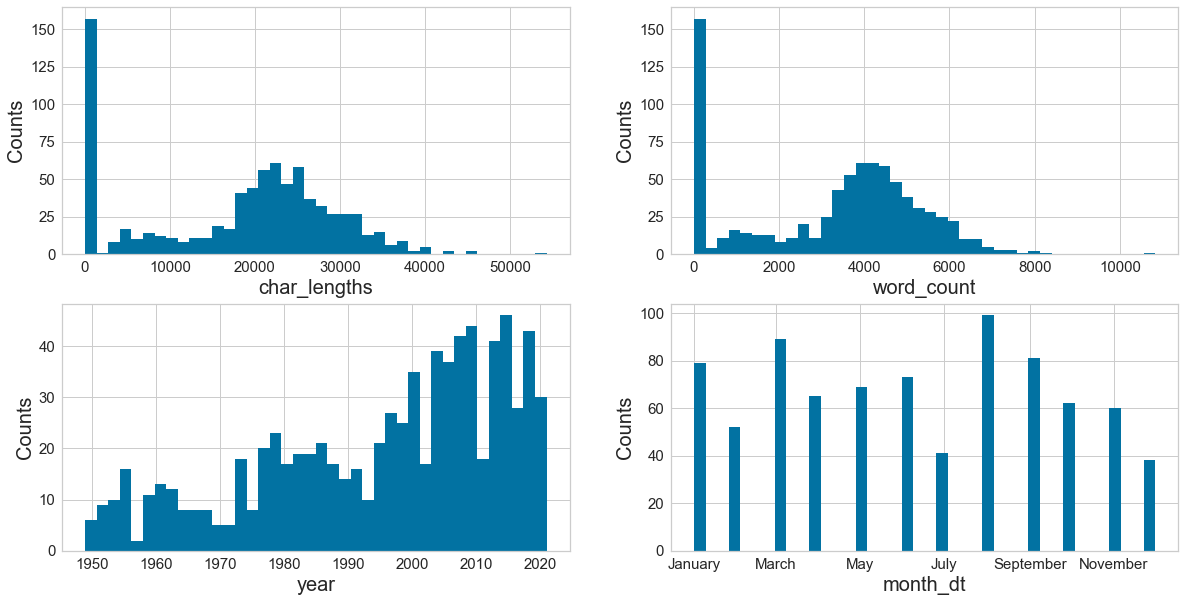

In [47]:
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
# set up the figure size
plt.rcParams['figure.figsize'] = (20, 10)

# make subplots
fig, axes = plt.subplots(nrows = 2, ncols = 2)

# Specify the features of interest
num_features = ['char_lengths', 'word_count', 'year', 'month_dt']
xaxes = num_features
yaxes = ['Counts', 'Counts', 'Counts', 'Counts']

# draw histograms
axes = axes.ravel()
for idx, ax in enumerate(axes):
    if idx == 3:
        date_form = DateFormatter('%B')
        ax.xaxis.set_major_formatter(date_form)
        ax.hist(df[num_features[idx]].dropna(), bins=40)
        ax.set_xlabel(xaxes[idx], fontsize=20)
        ax.set_ylabel(yaxes[idx], fontsize=20)
        ax.tick_params(axis='both', labelsize=15)    
    else:
        ax.hist(df[num_features[idx]].dropna(), bins=40)
        ax.set_xlabel(xaxes[idx], fontsize=20)
        ax.set_ylabel(yaxes[idx], fontsize=20)
        ax.tick_params(axis='both', labelsize=15)

plt.show()

Based on the plot above, we can make a few observations:  
- There are a number of websites that did not contain the sermon/talk text, and those will need to be removed from the final dataset.  
- The overall number of talks increased as time has gone on.
- August seems to be a popular month for people to give talks at Brigham Young University (suggesting that it coincides with the beginning of the school year)

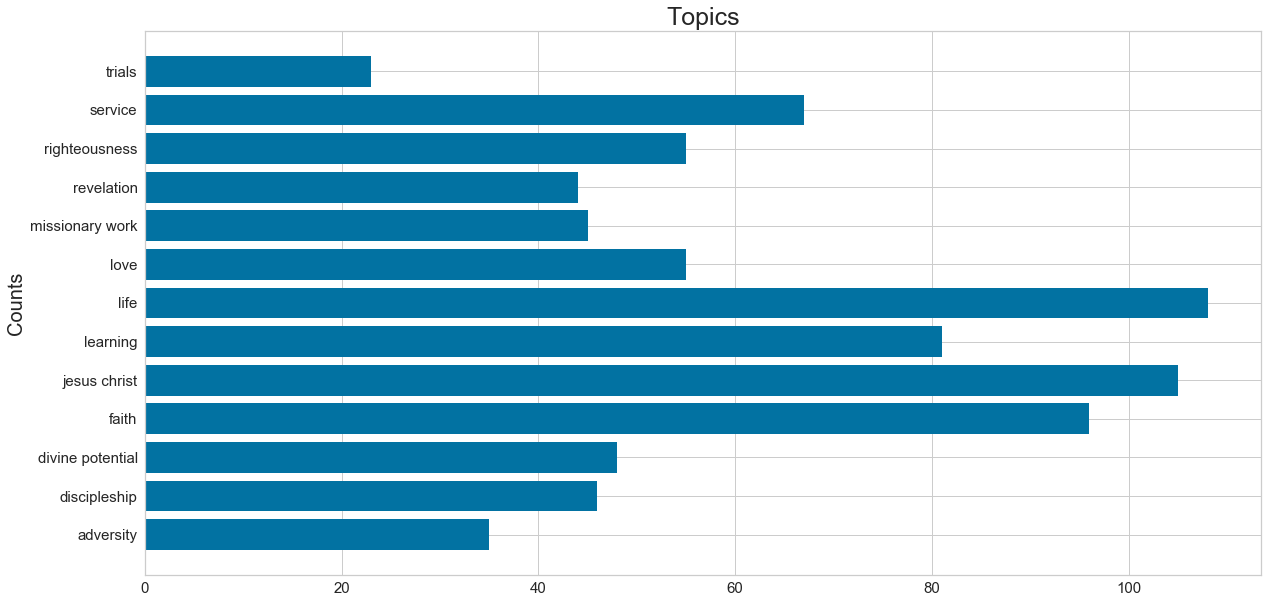

In [27]:
plt.rcParams['figure.figsize'] = (20, 10)

# make subplots
fig, axes = plt.subplots(nrows = 1, ncols = 1)

# make the data read to feed into the visulizer
X_Topics = df.groupby('topic_singular').size().reset_index(name='Counts')['topic_singular']
Y_Topics = df.groupby('topic_singular').size().reset_index(name='Counts')['Counts']
# make the bar plot
axes.barh(X_Topics, Y_Topics)
axes.set_title('Topics', fontsize=25)
axes.set_ylabel('Counts', fontsize=20)
axes.tick_params(axis='both', labelsize=15)

plt.show()


Observations from the topics bar chart:
- Jesus Christ and Life are the most popular topics (of the most popular topics).  
- All of the most popular seem to fall in line with a private religious university

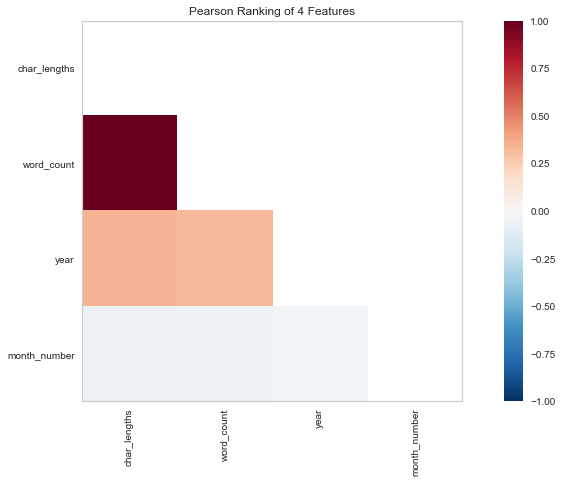

In [25]:
#set up the figure size
%matplotlib inline
plt.rcParams['figure.figsize'] = (15, 7)

# import the package for visulization of the correlation
from yellowbrick.features import Rank2D

# extract the numpy arrays from the data frame
X = df[num_features].values

# instantiate the visualizer with the Covariance ranking algorithm
visualizer = Rank2D(features=num_features, algorithm='pearson')
visualizer.fit(X)                # Fit the data to the visualizer
visualizer.transform(X)             # Transform the data
visualizer.poof(outpath="pcoords1.png") # Draw/show/poof the data
plt.show()

A few observations from the Pearson Ranking matrix plot:
- Word count and character length obviously have a strong correlation between them.  Perhaps one of these variables can be eliminated as to not confuse the training model.
- As the years increase (become more recent to our day), the speakers seem to have more to say (use more words).
- The later in the year, the less sermons are given.  Maybe this is due to July being a summer month with not a lot of the student body present on campus, and December has winter break.

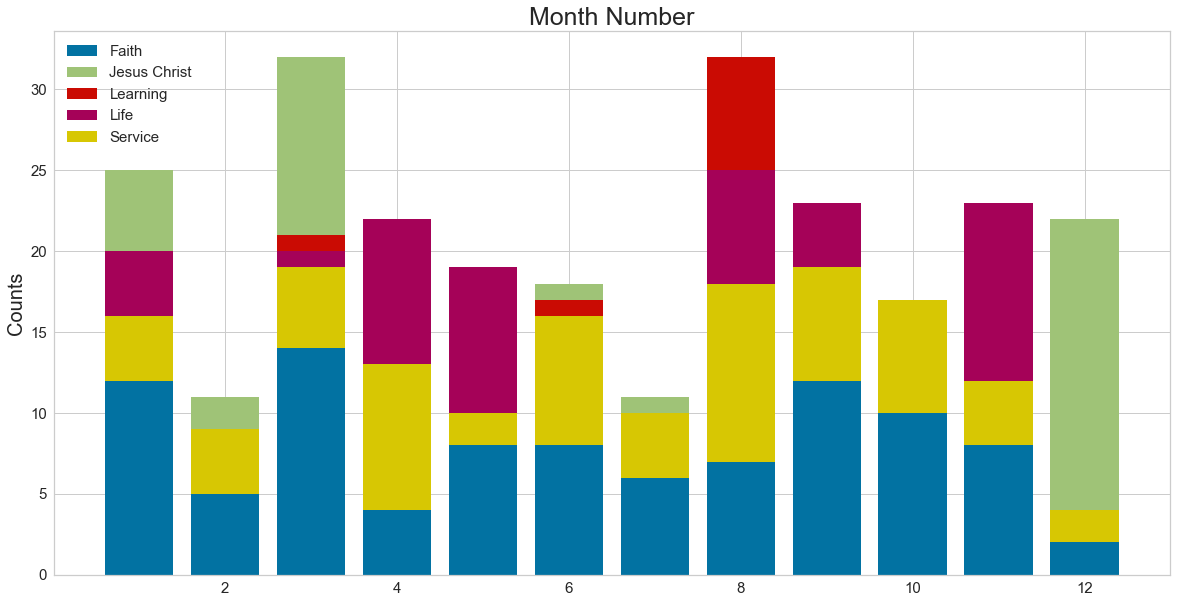

In [49]:
plt.rcParams['figure.figsize'] = (20, 10)

# make subplots
fig, axes = plt.subplots(nrows = 1, ncols = 1)

# make the data read to feed into the visulizer
month_number_faith = df[df['topic_singular']=='faith']['month_number'].value_counts()

month_number_jc = df[df['topic_singular']=='jesus christ']['month_number'].value_counts()
month_number_jc = month_number_jc.reindex(index = month_number_faith.index)

month_number_learning = df[df['topic_singular']=='learning']['month_number'].value_counts()
month_number_learning = month_number_learning.reindex(index = month_number_faith.index)

month_number_life = df[df['topic_singular']=='life']['month_number'].value_counts()
month_number_life = month_number_life.reindex(index = month_number_faith.index)

month_number_service = df[df['topic_singular']=='service']['month_number'].value_counts()
month_number_service = month_number_service.reindex(index = month_number_faith.index)
# make the bar plot
p1 = axes.bar(month_number_faith.index, month_number_faith.values)
p2 = axes.bar(month_number_jc.index, month_number_jc.values, bottom=month_number_faith.values)
p3 = axes.bar(month_number_learning.index, month_number_learning.values, bottom=month_number_faith.values)
p4 = axes.bar(month_number_life.index, month_number_life.values, bottom=month_number_faith.values)
p5 = axes.bar(month_number_service.index, month_number_service.values, bottom=month_number_faith.values)
# date_form = DateFormatter('%B')
# axes.xaxis.set_major_formatter(date_form)
axes.set_title('Month Number', fontsize=25)
axes.set_ylabel('Counts', fontsize=20)
axes.tick_params(axis='both', labelsize=15)
axes.legend((p1[0], p2[0], p3[0], p4[0], p5[0]), ('Faith', 'Jesus Christ', 'Learning', 'Life', 'Service'), fontsize = 15)

plt.show()


The following observations can be made from the chart above:

- August is the most popular month for talks, with an overwhelming majority of the learning topics being contained there.
- December is a popular month to discuss Jesus Christ (more than likely due to Christmas).
- Faith and Service is a common theme no matter the time of year.
- Jesus Christ as a topic is popular in March (perhaps due to Easter?).

It will be interesting as we continue on with this project how these variables will play into the predictability of the project.